In [1]:
%reset -f
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Activation, Flatten, Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard, EarlyStopping, ReduceLROnPlateau, CSVLogger
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.densenet import DenseNet121, DenseNet201
from tensorflow.keras.applications import NASNetLarge, Xception
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import pandas as pd
import cv2, os, os, git, glob, random
import numpy as np
from insectrec.utils import get_dataset, train_generator, valid_generator, augment_trainset, get_labelencoder_mapping
from tensorflow.keras.preprocessing.image import img_to_array
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
seed = 42
np.random.seed(seed)

created_data_path = f'/home/kalfasyan/data/images/sticky_plates/created_data'
path_crops_export = f'{created_data_path}/crops_export/'
path_images_augmented = f'{created_data_path}/images_augmented/'

clean = True
if clean:
    print("Deleting old augmented")
    os.system(f'rm -rf {path_images_augmented}*')

nb_classes = 1

if nb_classes == 3:
    target_classes = ['v','wmv','v(cy)','other']
elif nb_classes == 9:
    target_classes = ['m','v','bl','c','wmv','v(cy)','bv','sw','t','other']
elif nb_classes == 6:
    target_classes = ['m','v','bl','c','wmv','v(cy)','other']
elif nb_classes == 21:
    target_classes = ['m','v','bl','c','wmv','v(cy)','bv','gaasvlieg','grv','k','kever','nl','psylloidea','sp','sst','sw','t','vlieg','weg','wnv','wswl','other']
elif nb_classes == 1:
    target_classes = ['wmv', 'other']

epochs = 100
batch_size = 32
monitor='val_accuracy'
es_patience=7
rlr_patience=3
img_dim = 150
modelname = f'DenseNet121_{nb_classes}classes_{img_dim}'

Deleting old augmented


In [2]:
# Creating le for encoding labels
le = LabelEncoder()

# Creating dataframe with all the original data (x: filenames, textlabels, y: nummerical labels)
df_2019 = pd.DataFrame()
df_2019['x'] = pd.Series(glob.glob(f"{path_crops_export}/*/2019*.jpg"))
df_2019['pname'] = df_2019['x'].apply(lambda p: p.split('/')[-1][:-4])
df_2019['pname'] = df_2019['pname'].apply(lambda x: '_'.join(x.split('_')[:-1]))
df_2019['y_text'] = df_2019['x'].apply(lambda x: x.split('/')[-2])
df_2019['y_text'] = df_2019['y_text'].apply(lambda x: 'other' if x not in target_classes else x)

df_2019.drop(df_2019[df_2019.y_text == 'other'].sample(1, random_state=42).index, axis='index', inplace=True)

df_2019['y'] = le.fit_transform(df_2019.y_text)

In [3]:
# df_2019.y_text.value_counts()

Test set class balance
other    1806
wmv       637
Name: y_text, dtype: int64


/home/kalfasyan/anaconda3/envs/objdetect/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:1192: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)
/home/kalfasyan/anaconda3/envs/objdetect/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:1192: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


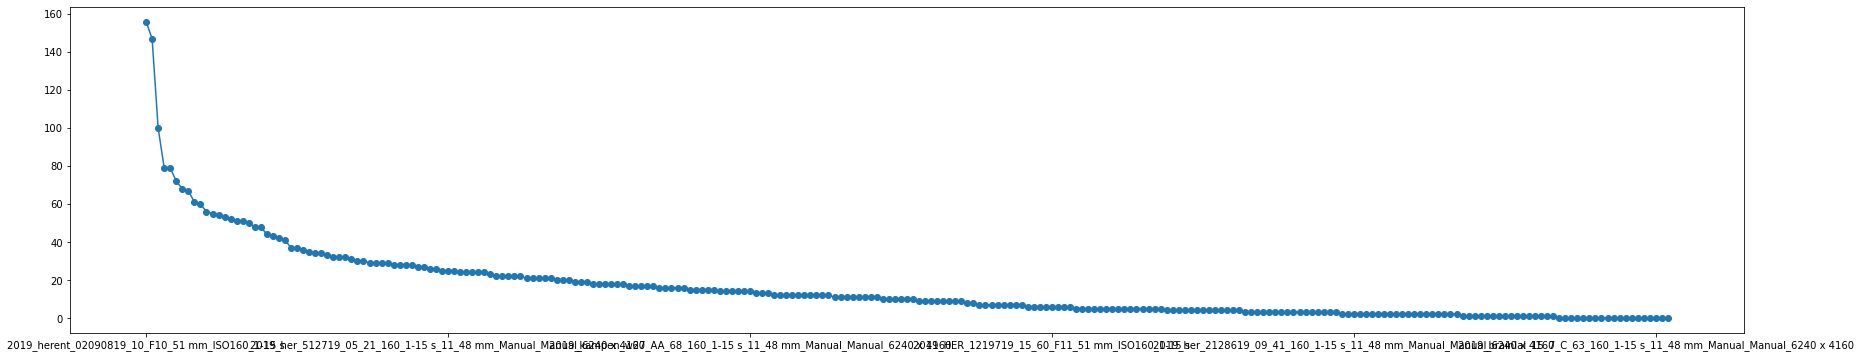

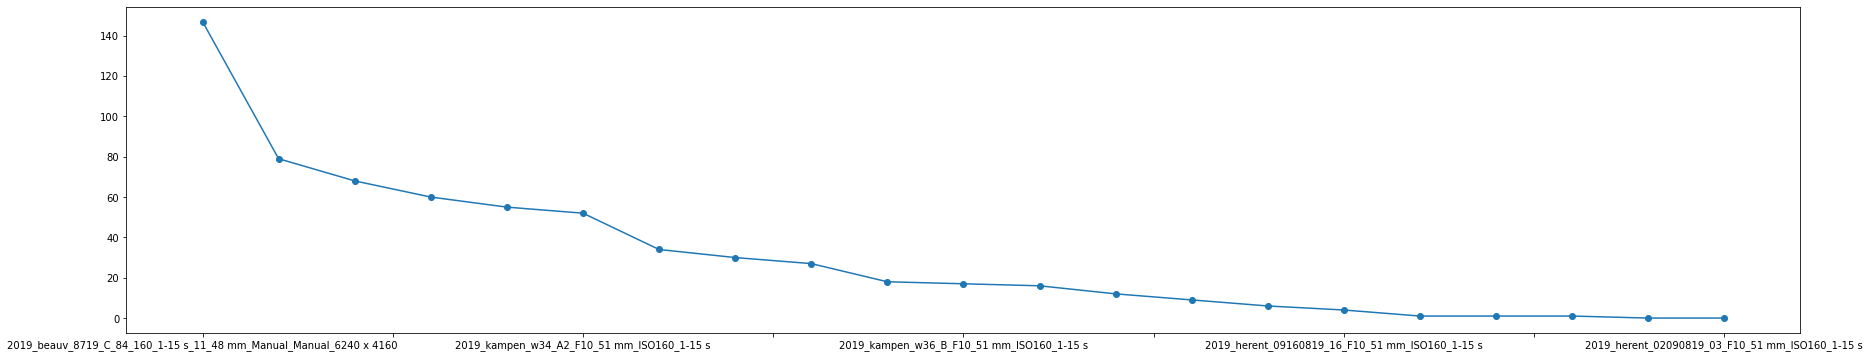

In [4]:
# Sampling some test plates. 2 from first 5, 2 from next five....
target_insect_dict = {}
for i, sub in df_2019.groupby(['pname']):
    try:
        target_insect_dict[i] = sub['y_text'][sub['y_text']=='wmv'].value_counts()[0]
    except:
        target_insect_dict[i] = 0
ser = pd.Series(target_insect_dict, index=target_insect_dict.keys()).sort_values(ascending=False)
test_plates = []
test_plates.extend(ser.iloc[:5].sample(2, random_state=42).index.values.tolist())
test_plates.extend(ser.iloc[5:10].sample(2, random_state=42).index.values.tolist())
test_plates.extend(ser.iloc[10:15].sample(2, random_state=42).index.values.tolist())
test_plates.extend(ser.iloc[20:].sample(15, random_state=42).index.values.tolist())
test_plates = ser.loc[test_plates].sort_values(ascending=False).index.tolist()
# Plotting
ser.plot(marker='o', figsize=(30,6))
plt.figure()
ser.loc[test_plates].sort_values(ascending=False).plot(marker='o', figsize=(30,6))

X_test = df_2019.x[df_2019.pname.isin(test_plates)]
y_test = df_2019.y[df_2019.pname.isin(test_plates)]
print("Test set class balance")
print(df_2019[df_2019.pname.isin(test_plates) ].y_text.value_counts())

## Model

In [5]:
base_model = DenseNet121(include_top=False, weights=None, 
                        input_shape=(img_dim,img_dim,3))
# EfficientNetB2
# base_model = DenseNet121(include_top=False, weights='imagenet', 
#                         input_shape=(img_dim,img_dim,3))
x = base_model.output
x = GlobalAveragePooling2D()(x)
# x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(nb_classes+1, activation=None)(x)
predictions = Activation('softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

top_weights_path = f"{created_data_path}/weights/{modelname}.h5"
model.load_weights(top_weights_path)

pred = model.predict(valid_generator(X_test.tolist(), y_test.tolist(), batch_size=batch_size, nb_classes=nb_classes+1, img_dim=img_dim), 
                         steps= len(X_test) / batch_size, 
                         verbose=1)
y_pred = np.argmax(pred, axis=1)

get_labelencoder_mapping(le)
name_map = dict(zip(le.transform(le.classes_), le.classes_))
inv_name_map = {v: k for k, v in name_map.items()}

print(name_map)

77/76 [==============================] - 6s 84ms/step
{0: 'other', 1: 'wmv'}


## Confusion matrix

0.8652142431212199


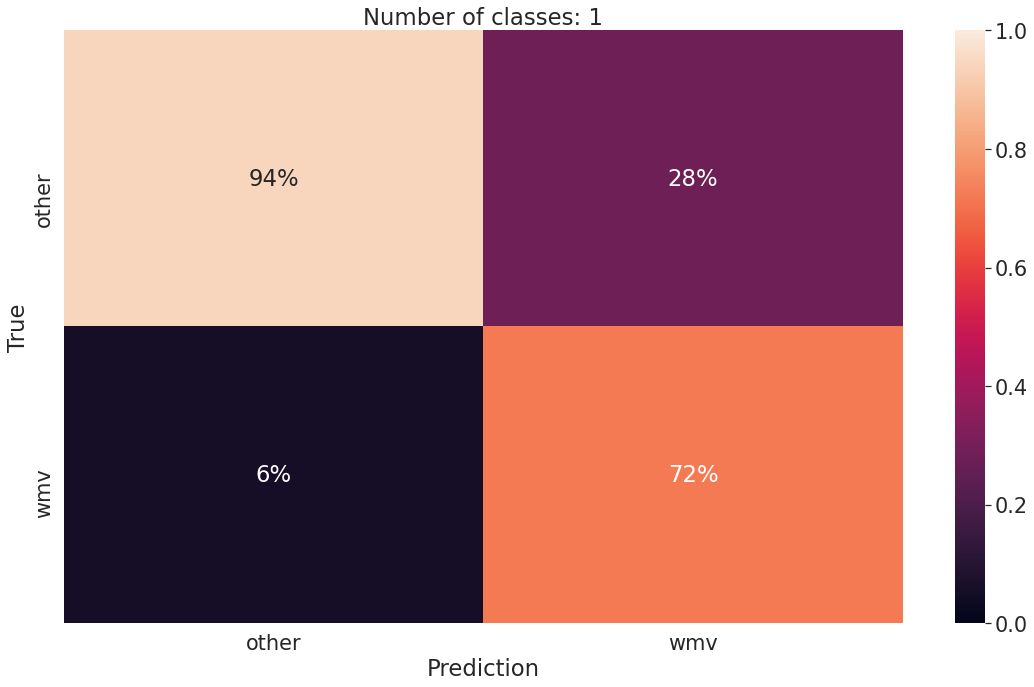

In [6]:
from sklearn.metrics import accuracy_score, balanced_accuracy_score, confusion_matrix
import seaborn as sns
print(balanced_accuracy_score(y_test, y_pred))

sns.set(font_scale=1.9)
plt.figure(figsize=(16,10))
cm = confusion_matrix(le.fit_transform(y_test), y_pred, normalize='pred')

sns.heatmap(cm, annot=True, xticklabels=list(name_map.values()), yticklabels=list(name_map.values()), fmt='.0%',
           vmin=0, vmax=1)
plt.ylabel('True')
plt.xlabel('Prediction')
plt.title(f"Number of classes: {nb_classes}")
sns.set(font_scale=1.8)
plt.tight_layout()
plt.savefig(f"{created_data_path}/results/confusionmatrix_2019data_{nb_classes}classes.png")

## 2019 test plates - Predicted # of wmvs

/home/kalfasyan/anaconda3/envs/objdetect/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/kalfasyan/anaconda3/envs/objdetect/lib/python3.7/site-packages/seaborn/axisgrid.py:1840: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))


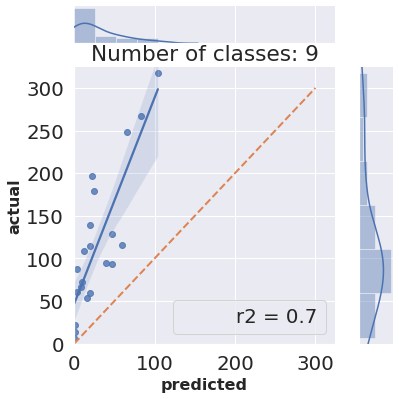

In [8]:
from scipy import stats
def r2(x, y):
    return stats.pearsonr(x, y)[0] ** 2

df_test = df_2019[df_2019.pname.isin(test_plates)]
df_test['pred'] = y_pred

actual, predicted = [], []
for i, sub in df_test.groupby('pname'):
    actual.append(sub.shape[0])
    predicted.append(len(sub[sub.pred==inv_name_map['wmv']]))

h = sns.jointplot(predicted,actual, kind="reg", stat_func=r2); plt.ylim(-.9,325); plt.xlim(-.9,325);
h.set_axis_labels('predicted', 'actual', fontsize=16,fontweight='bold')
h.ax_joint.plot([0,300], [0,300], '--', linewidth = 2)
plt.tight_layout()
plt.title(f"Number of classes: {nb_classes}")

plt.savefig(f"{created_data_path}/results/jointplot_predicted#2019data_{nb_classes}classes.png")

## 2020 data (all plates so far)

In [9]:
target_insect = 'wmv'

# Creating dataframe with all the original data (x: filenames, textlabels, y: nummerical labels
df_2020 = pd.DataFrame()
df_2020['x'] = pd.Series(glob.glob(f"{path_crops_export}/*/2020*.jpg"))
df_2020['pname'] = df_2020['x'].apply(lambda p: p.split('/')[-1][:-4])
df_2020['pname'] = df_2020['pname'].apply(lambda x: '_'.join(x.split('_')[:-1]))
df_2020['y_text'] = df_2020['x'].apply(lambda x: x.split('/')[-2])
df_2020['y_text'] = df_2020['y_text'].apply(lambda x: 'other' if x not in target_classes else x)

# df_2020.drop(df_2020[df_2020.y_text == 'other'].sample(1, random_state=42).index, axis='index', inplace=True)

df_2020['y'] = le.fit_transform(df_2020.y_text)

pred2 = model.predict(valid_generator(df_2020.x.tolist(), df_2020.y.tolist(), batch_size=batch_size, nb_classes=nb_classes+1, img_dim=img_dim), 
                         steps= len(df_2020.x.tolist()) / batch_size, 
                         verbose=1)
y_pred2 = np.argmax(pred2, axis=1)
df_2020['pred'] = y_pred2

373/372 [==============================] - 64s 172ms/step


## Whole 2020  -  Joint plot (actual vs predicted)

In [10]:
# df_2020[df_2020.pred==3].y_text.value_counts()

In [11]:
sub[(sub.pred==inv_name_map[target_insect]) & (sub.y_text==target_insect)].shape

(0, 5)

/home/kalfasyan/anaconda3/envs/objdetect/lib/python3.7/site-packages/seaborn/axisgrid.py:1840: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))


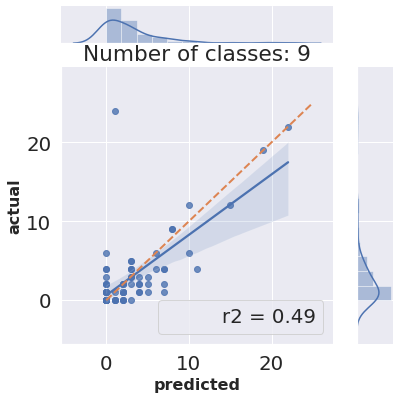

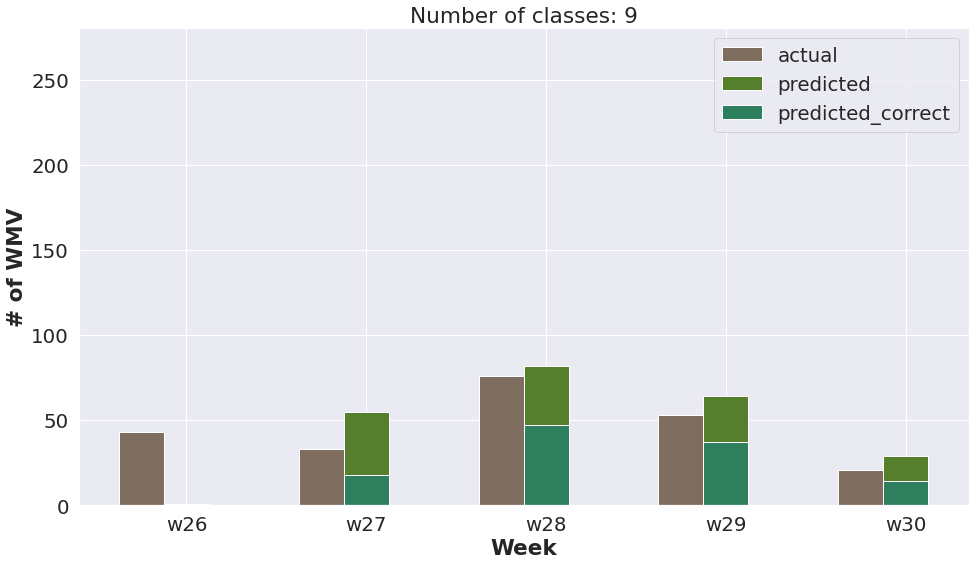

In [12]:
from insectrec.utils import to_weeknr
from scipy import stats
def r2(x, y):
    return stats.pearsonr(x, y)[0] ** 2

# df_2020 = df_2020[df_2020.y_text==target_insect]

actual, predicted, predicted_correct = [], [], []
for n, (i, sub) in enumerate(df_2020.groupby('pname')):
    real_nr = len(sub[sub.y_text==target_insect])
    pred_nr = len(sub[sub.pred==inv_name_map[target_insect]])
    correct_nr = len(sub[(sub.pred==inv_name_map[target_insect]) & (sub.y_text==target_insect)])
    actual.append(real_nr)
    predicted.append(pred_nr)

h = sns.jointplot(x=predicted, y=actual, kind="reg", stat_func=r2); 
h.set_axis_labels(xlabel='predicted', ylabel='actual', fontsize=16,fontweight='bold')
plt.tight_layout()
# plt.plot([0, 1], [0, 1])
# plt.plot([0, 4], [1.5, 0], linewidth=2)
h.ax_joint.plot([0,25], [0,25], '--', linewidth = 2)
plt.title(f"Number of classes: {nb_classes}")

plt.savefig(f"{created_data_path}/results/jointplot_predicted#2020data_{nb_classes}classes.png")
#####################

df_2020['date'] = df_2020.pname.apply(lambda x: x.split('_')[2])
df_2020['weeknr'] = df_2020['date'].apply(lambda x: x if x.startswith('w') else to_weeknr(date=x))

# EXCLUDING WEIRD WEEKS
df_2020 = df_2020[~df_2020.weeknr.isin(['w04','w05','w32'])]

results = [{"week": None,"actual":[], "predicted":[], "predicted_correct": [], 
            "cm": None, "nrofplates": None, "nrofinsects": None} for i in df_2020.weeknr.unique().tolist()]
for i, (w,sub) in enumerate(df_2020.groupby('weeknr')):
    results[i]['week'] = w
    results[i]['actual'] = len(sub[sub.y_text==target_insect])
    results[i]['predicted_correct'] = len(sub[(sub.pred==inv_name_map[target_insect]) & (sub.y_text==target_insect)])
    results[i]['predicted'] = len(sub[sub.pred==inv_name_map[target_insect]])
    results[i]['cm'] = confusion_matrix(y_true=sub.y.values, y_pred=sub.pred.values)
    results[i]['nrofplates'] = len(df_2020[df_2020.weeknr==w].pname.unique())
    results[i]['nrofinsects'] = sub.shape[0]
# print(results[0])

###########################
import matplotlib.pyplot as plt
plt.figure(figsize=(14,8))
# set width of bar
barWidth = 0.25
sns.set(font_scale=1.8)
# set height of bar
bars1 = [i['actual'] for i in results]
bars2 = [i['predicted'] for i in results]
bars3 = [i['predicted_correct'] for i in results]

# Set position of bar on X axis
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]
 
# Make the plot
plt.bar(r1, bars1, color='#7f6d5f', width=barWidth, edgecolor=None, label='actual')
plt.bar(r2, bars2, color='#557f2d', width=barWidth, edgecolor=None, label='predicted')
plt.bar(r2, bars3, color='#2d7f5e', width=barWidth, edgecolor=None, label='predicted_correct')
 
# Add xticks on the middle of the group bars
plt.xlabel('Week', fontweight='bold')
plt.ylabel('# of WMV', fontweight='bold')
plt.ylim(0,280)
plt.xticks([r + barWidth for r in range(len(bars1))], [i['week'] for i in results])

# Create legend & Show graphic
plt.legend()
plt.tight_layout()
plt.title(f"Number of classes: {nb_classes}")
plt.savefig(f"{created_data_path}/results/histogram_predicted#2020data_{nb_classes}classes.png")

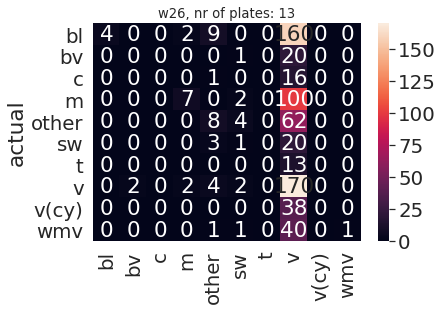

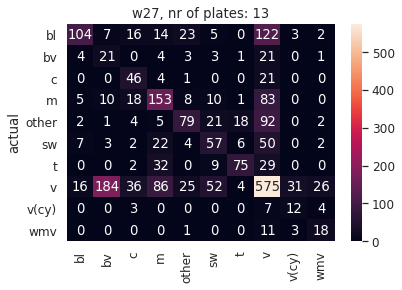

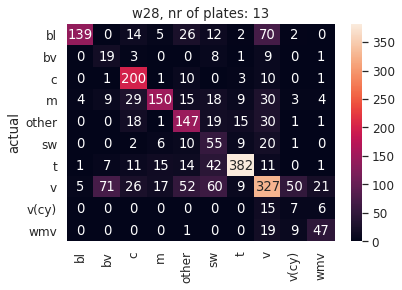

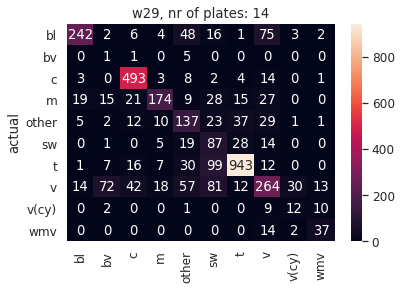

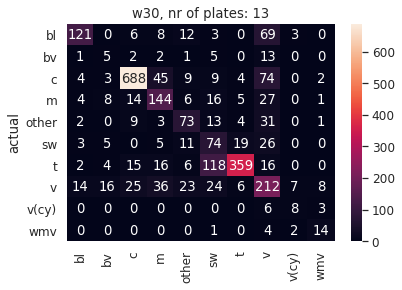

In [12]:
for i,r in enumerate(results):
    plt.figure()
    cm = results[i]['cm']
#     cm = cm / cm.astype(np.float).sum(axis=0)
    sns.heatmap(cm, annot=True, fmt='g', xticklabels=list(name_map.values()), yticklabels=list(name_map.values()))
    sns.set(font_scale=1.1)
    plt.title(f"{results[i]['week']}, nr of plates: {results[i]['nrofplates']}")
    plt.ylabel('actual')